In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing 
from sklearn.impute import KNNImputer

# Read data

In [6]:
train = pd.read_csv("/content/drive/My Drive/JH_HealthAnalytics2/train.csv")
train_data_dict = pd.read_csv("/content/drive/My Drive/JH_HealthAnalytics2/train_data_dict.csv")
test = pd.read_csv("/content/drive/My Drive/JH_HealthAnalytics2/test.csv")
submission = pd.read_csv("/content/drive/My Drive/JH_HealthAnalytics2/sample_submission_lfbv3c3.csv")

# Analysis

In [7]:
train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [8]:
train_data_dict

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


In [9]:
train.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [10]:
test.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,318440,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,318442,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,318443,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


In [11]:
test.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                              35
patientid                               0
City_Code_Patient                    2157
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
dtype: int64

There are null values in Bed Grade

There are many null values in City Code Patient

## Combine train and test

In [12]:
def combine_df(train,test):
  train['is_train'] = 1
  test['is_train'] = 0
  combined = pd.concat([train,test],axis=0)
  combined['Stay'].fillna(-999,inplace=True)
  return combined

In [13]:
combined = combine_df(train,test)

## Further analysis

In [14]:
combined.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,is_train
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,1
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,1
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,1
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,1
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,1


In [17]:
combined['Ward_Facility_Code'].value_counts()

F    161470
E     79058
D     74312
C     50279
B     50116
A     40260
Name: Ward_Facility_Code, dtype: int64

In [16]:
combined['Type of Admission'].value_counts()

Trauma       217672
Emergency    168363
Urgent        69460
Name: Type of Admission, dtype: int64

In [15]:
combined['Department'].value_counts()

gynecology            356688
anesthesia             42358
radiotherapy           41033
TB & Chest disease     13751
surgery                 1665
Name: Department, dtype: int64

In [25]:
combined[combined['City_Code_Patient'].isnull()]

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,is_train
191,192,14,a,1,X,2,radiotherapy,Q,E,3.0,122110,NaN,Emergency,Minor,2,71-80,9096.0,51-60,1
192,193,30,c,3,Z,2,anesthesia,Q,A,4.0,122110,NaN,Trauma,Minor,2,71-80,5098.0,31-40,1
193,194,27,a,7,Y,2,radiotherapy,P,C,3.0,122110,NaN,Trauma,Minor,2,71-80,7776.0,21-30,1
194,195,27,a,7,Y,2,anesthesia,Q,C,3.0,122110,NaN,Trauma,Minor,2,71-80,5988.0,11-20,1
195,196,25,e,1,X,3,radiotherapy,S,E,3.0,122110,NaN,Urgent,Minor,2,71-80,5333.0,21-30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136821,455260,32,f,9,Y,3,gynecology,S,B,2.0,98468,NaN,Emergency,Moderate,2,61-70,4021.0,-999,0
136831,455270,6,a,6,X,5,anesthesia,Q,F,2.0,22980,NaN,Emergency,Minor,4,61-70,3989.0,-999,0
136911,455350,28,b,11,X,3,TB & Chest disease,R,F,3.0,66381,NaN,Emergency,Moderate,5,61-70,4171.0,-999,0
136943,455382,23,a,6,X,4,gynecology,Q,F,4.0,75055,NaN,Emergency,Minor,4,41-50,4445.0,-999,0


In [26]:
combined[combined['patientid'] == 31397]

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,is_train
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,1
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,1
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,1
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,1
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,1
5,6,23,a,6,X,2,anesthesia,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,4449.0,11-20,1
6,7,32,f,9,Y,1,radiotherapy,S,B,3.0,31397,7.0,Emergency,Extreme,2,51-60,6167.0,0-10,1
7,8,23,a,6,X,4,radiotherapy,Q,F,3.0,31397,7.0,Trauma,Extreme,2,51-60,5571.0,41-50,1
8,9,1,d,10,Y,2,gynecology,R,B,4.0,31397,7.0,Trauma,Extreme,2,51-60,7223.0,51-60,1
9,10,10,e,1,X,2,gynecology,S,E,3.0,31397,7.0,Trauma,Extreme,2,51-60,6056.0,31-40,1


## Grouped features

In [27]:
age_groups = {'41-50':"middle",
'31-40':'young',
'51-60':'middle',
'21-30':'young',
'71-80':'old',
'61-70':'old',
'11-20':'very young',
'81-90':'older',
'0-10': 'very young',
'91-100':'older'}

In [28]:
combined['Age_group'] = combined['Age'].map(age_groups)

In [29]:
combined.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,is_train,Age_group
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,1,middle
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,1,middle
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,1,middle
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,1,middle
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,1,middle


In [30]:
combined.drop("Age",axis=1,inplace=True)

## Label encode all the categorical variables for future use

In [31]:
combined.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             148
patientid                               0
City_Code_Patient                    6689
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Admission_Deposit                       0
Stay                                    0
is_train                                0
Age_group                               0
dtype: int64

In [32]:
combined.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Admission_Deposit,Stay,is_train,Age_group
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,4911.0,0-10,1,middle
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,5954.0,41-50,1,middle
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,4745.0,31-40,1,middle
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,7272.0,41-50,1,middle
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,5558.0,41-50,1,middle


In [38]:
Age_group_label = {'very young': 0,
                   'young': 1,
                   'middle': 2,
                   'old': 3,
                   'older': 4}
combined['Age_group'] = combined['Age_group'].map(Age_group_label)

In [40]:
illness_severity_label = {'Minor': 0,
                   'Moderate': 1,
                   'Extreme': 2}
combined['Severity of Illness'] = combined['Severity of Illness'].map(illness_severity_label)

In [43]:
string_columns = ['Hospital_type_code','Hospital_region_code','Department','Ward_Type','Ward_Facility_Code',\
                  'Type of Admission']
df_to_encode = combined[string_columns]


In [44]:
combined['Hospital_region_code'].value_counts()

X    190849
Y    174707
Z     89939
Name: Hospital_region_code, dtype: int64

In [45]:
df_to_encode = df_to_encode.apply(preprocessing.LabelEncoder().fit_transform)
df_to_encode.head()

,Hospital_type_code,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Type of Admission
0,2,2,3,2,5,0
1,2,2,3,3,5,1
2,4,0,1,3,4,1
3,1,1,3,2,3,1
4,1,1,3,3,3,1


In [46]:
combined.drop(string_columns,axis=1,inplace=True)
combined = pd.concat([combined, df_to_encode],axis=1)

In [47]:
combined.isnull().sum()

case_id                                 0
Hospital_code                           0
City_Code_Hospital                      0
Available Extra Rooms in Hospital       0
Bed Grade                             148
patientid                               0
City_Code_Patient                    6689
Severity of Illness                     0
Visitors with Patient                   0
Admission_Deposit                       0
Stay                                    0
is_train                                0
Age_group                               0
Hospital_type_code                      0
Hospital_region_code                    0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Type of Admission                       0
dtype: int64

## Fill Na values

In [48]:
combined.groupby("Hospital_region_code")['Bed Grade'].mean()

Hospital_region_code
0    2.713018
1    2.516473
2    2.666496
Name: Bed Grade, dtype: float64

In [49]:
combined['Bed Grade'].value_counts()

2.0    176451
3.0    158942
4.0     82387
1.0     37567
Name: Bed Grade, dtype: int64

In [50]:
## For each hospital type what is the dominant bed code ?
## This is to see that each hospital type follows different standards

In [51]:
combined.groupby(['Hospital_type_code','Bed Grade'])['Bed Grade'].count()

Hospital_type_code  Bed Grade
0                   1.0          19818
                    2.0          78959
                    3.0          71221
                    4.0          34584
1                   1.0           6890
                    2.0          38005
                    3.0          34451
                    4.0          19538
2                   1.0           4731
                    2.0          26049
                    3.0          22713
                    4.0          12654
3                   1.0           1976
                    2.0          11926
                    3.0           9726
                    4.0           5420
4                   1.0           2570
                    2.0          12363
                    3.0          13269
                    4.0           7226
5                   1.0            963
                    2.0           5795
                    3.0           5824
                    4.0           2670
6                   1.0           

In [52]:
combined.groupby(['Type of Admission','Bed Grade'])['Bed Grade'].count()

Type of Admission  Bed Grade
0                  1.0          21247
                   2.0          71750
                   3.0          51292
                   4.0          24008
1                  1.0          11783
                   2.0          79956
                   3.0          82280
                   4.0          43571
2                  1.0           4537
                   2.0          24745
                   3.0          25370
                   4.0          14808
Name: Bed Grade, dtype: int64

In [53]:
combined.groupby(['Department','Bed Grade'])['Bed Grade'].count()

Department  Bed Grade
0           1.0             773
            2.0            4880
            3.0            5151
            4.0            2944
1           1.0             452
            2.0           10068
            3.0           20163
            4.0           11673
2           1.0           32168
            2.0          144816
            3.0          119532
            4.0           60042
3           1.0            3870
            2.0           15925
            3.0           13710
            4.0            7515
4           1.0             304
            2.0             762
            3.0             386
            4.0             213
Name: Bed Grade, dtype: int64

In [54]:
combined.head()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Severity of Illness,Visitors with Patient,Admission_Deposit,Stay,is_train,Age_group,Hospital_type_code,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Type of Admission
0,1,8,3,3,2.0,31397,7.0,2,2,4911.0,0-10,1,2,2,2,3,2,5,0
1,2,2,5,2,2.0,31397,7.0,2,2,5954.0,41-50,1,2,2,2,3,3,5,1
2,3,10,1,2,2.0,31397,7.0,2,2,4745.0,31-40,1,2,4,0,1,3,4,1
3,4,26,2,2,2.0,31397,7.0,2,2,7272.0,41-50,1,2,1,1,3,2,3,1
4,5,26,2,2,2.0,31397,7.0,2,2,5558.0,41-50,1,2,1,1,3,3,3,1


In [55]:
combined.isnull().sum()

case_id                                 0
Hospital_code                           0
City_Code_Hospital                      0
Available Extra Rooms in Hospital       0
Bed Grade                             148
patientid                               0
City_Code_Patient                    6689
Severity of Illness                     0
Visitors with Patient                   0
Admission_Deposit                       0
Stay                                    0
is_train                                0
Age_group                               0
Hospital_type_code                      0
Hospital_region_code                    0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Type of Admission                       0
dtype: int64

In [56]:
combined.dtypes

case_id                                int64
Hospital_code                          int64
City_Code_Hospital                     int64
Available Extra Rooms in Hospital      int64
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Severity of Illness                    int64
Visitors with Patient                  int64
Admission_Deposit                    float64
Stay                                  object
is_train                               int64
Age_group                              int64
Hospital_type_code                     int64
Hospital_region_code                   int64
Department                             int64
Ward_Type                              int64
Ward_Facility_Code                     int64
Type of Admission                      int64
dtype: object

In [57]:
combined.isnull().sum()

case_id                                 0
Hospital_code                           0
City_Code_Hospital                      0
Available Extra Rooms in Hospital       0
Bed Grade                             148
patientid                               0
City_Code_Patient                    6689
Severity of Illness                     0
Visitors with Patient                   0
Admission_Deposit                       0
Stay                                    0
is_train                                0
Age_group                               0
Hospital_type_code                      0
Hospital_region_code                    0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Type of Admission                       0
dtype: int64

In [58]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
combined_df = imputer.fit_transform(combined.drop(['Stay','case_id'],axis=1))

In [59]:
combined.head()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Severity of Illness,Visitors with Patient,Admission_Deposit,Stay,is_train,Age_group,Hospital_type_code,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Type of Admission
0,1,8,3,3,2.0,31397,7.0,2,2,4911.0,0-10,1,2,2,2,3,2,5,0
1,2,2,5,2,2.0,31397,7.0,2,2,5954.0,41-50,1,2,2,2,3,3,5,1
2,3,10,1,2,2.0,31397,7.0,2,2,4745.0,31-40,1,2,4,0,1,3,4,1
3,4,26,2,2,2.0,31397,7.0,2,2,7272.0,41-50,1,2,1,1,3,2,3,1
4,5,26,2,2,2.0,31397,7.0,2,2,5558.0,41-50,1,2,1,1,3,3,3,1


In [60]:
combined_df[:,3]

array([2., 2., 2., ..., 4., 4., 4.])

In [61]:
combined_df[:,5]

array([ 7.,  7.,  7., ..., 12., 10.,  3.])

In [62]:
combined.drop(['Bed Grade','City_Code_Patient'],axis=1,inplace=True)
combined['Bed Grade'] = combined_df[:,3]
combined['City_Code_Patient'] = combined_df[:,5]

In [63]:
combined.head()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,patientid,Severity of Illness,Visitors with Patient,Admission_Deposit,Stay,is_train,Age_group,Hospital_type_code,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Type of Admission,Bed Grade,City_Code_Patient
0,1,8,3,3,31397,2,2,4911.0,0-10,1,2,2,2,3,2,5,0,2.0,7.0
1,2,2,5,2,31397,2,2,5954.0,41-50,1,2,2,2,3,3,5,1,2.0,7.0
2,3,10,1,2,31397,2,2,4745.0,31-40,1,2,4,0,1,3,4,1,2.0,7.0
3,4,26,2,2,31397,2,2,7272.0,41-50,1,2,1,1,3,2,3,1,2.0,7.0
4,5,26,2,2,31397,2,2,5558.0,41-50,1,2,1,1,3,3,3,1,2.0,7.0


In [64]:
train['Stay'].value_counts()

21-30                 87491
11-20                 78139
31-40                 55159
51-60                 35018
0-10                  23604
41-50                 11743
71-80                 10254
More than 100 Days     6683
81-90                  4838
91-100                 2765
61-70                  2744
Name: Stay, dtype: int64

## Normalize

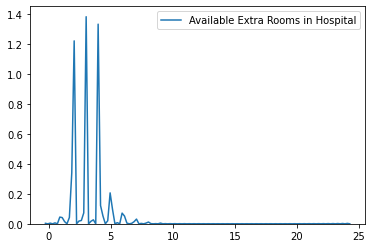

In [65]:
sns.kdeplot(combined['Available Extra Rooms in Hospital'])

In [66]:
def z_score(x, x_mean, x_std):
  return (x - x_mean) / x_std


In [67]:
# extra_rooms_mean = combined['Available Extra Rooms in Hospital'].mean()
# extra_rooms_std = combined['Available Extra Rooms in Hospital'].std()

In [68]:
# combined['Available Extra Rooms in Hospital'] = combined['Available Extra Rooms in Hospital'].apply(z_score, args=(extra_rooms_mean, extra_rooms_std))

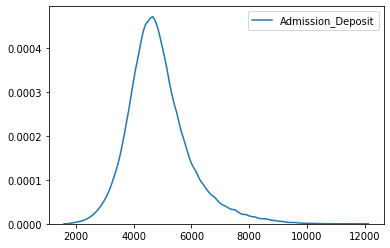

In [69]:
sns.kdeplot(combined['Admission_Deposit'])

In [70]:
admission_deposit_mean = combined['Admission_Deposit'].mean()
admission_deposit_std = combined['Admission_Deposit'].std()

In [71]:
combined['Admission_Deposit'] = combined['Admission_Deposit'].apply(z_score, args=(admission_deposit_mean, admission_deposit_std))

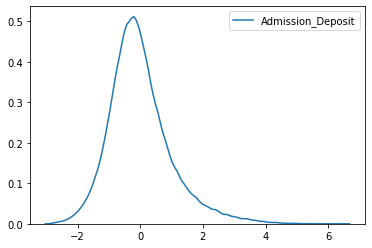

In [72]:
sns.kdeplot(combined['Admission_Deposit'])

In [73]:
combined.head()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,patientid,Severity of Illness,Visitors with Patient,Admission_Deposit,Stay,is_train,Age_group,Hospital_type_code,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Type of Admission,Bed Grade,City_Code_Patient
0,1,8,3,3,31397,2,2,0.030937,0-10,1,2,2,2,3,2,5,0,2.0,7.0
1,2,2,5,2,31397,2,2,0.992243,41-50,1,2,2,2,3,3,5,1,2.0,7.0
2,3,10,1,2,31397,2,2,-0.122061,31-40,1,2,4,0,1,3,4,1,2.0,7.0
3,4,26,2,2,31397,2,2,2.207010,41-50,1,2,1,1,3,2,3,1,2.0,7.0
4,5,26,2,2,31397,2,2,0.627260,41-50,1,2,1,1,3,3,3,1,2.0,7.0


In [75]:
import scipy.stats as stats

In [ ]:
combined['Available Extra Rooms in Hospital']+1

0         4
1         3
2         3
3         3
4         3
         ..
137052    5
137053    3
137054    3
137055    3
137056    4
Name: Available Extra Rooms in Hospital, Length: 455495, dtype: int64

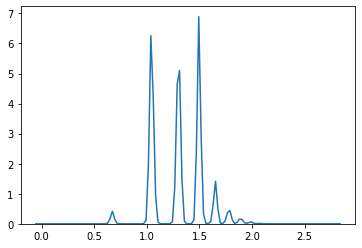

In [76]:
sns.kdeplot(pd.Series(stats.boxcox(combined['Available Extra Rooms in Hospital']+1)[0]))

In [77]:
combined['Available Extra Rooms in Hospital boxcox'] = stats.boxcox(combined['Available Extra Rooms in Hospital']+1)[0]

In [78]:
combined['Available Extra Rooms in Hospital log'] = np.log1p(combined['Available Extra Rooms in Hospital'])

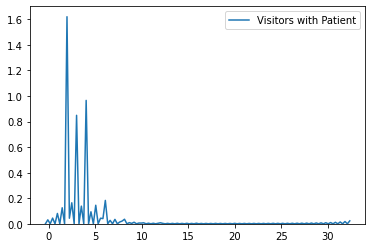

In [104]:
sns.kdeplot(combined['Visitors with Patient'])

In [108]:
combined['Visitors with Patient log']  = np.log1p(combined['Visitors with Patient'])

## Target encoding

In [79]:
target_encode = {'0-10':0,
 '11-20':1,
 '21-30':2,
 '31-40':3,
 '41-50':4,
 '51-60':5,
 '61-70':6,
 '71-80':7,
 '81-90':8,
 '91-100':9,
 'More than 100 Days':10}


In [80]:
combined['Stay'] = combined['Stay'].map(target_encode)

In [81]:
train_final = combined[combined['is_train'] == 1]
test_final = combined[combined['is_train'] == 0]

In [82]:
inv_map = {v: k for k, v in target_encode.items()}

In [83]:
train_final.to_csv("train_final.csv",index=False)
test_final.to_csv("test_final.csv",index=False)

In [84]:
combined.to_csv("combined_final.csv",index=False)

# Feature Engineering

In [85]:
combined.columns

Index(['case_id', 'Hospital_code', 'City_Code_Hospital',
       'Available Extra Rooms in Hospital', 'patientid', 'Severity of Illness',
       'Visitors with Patient', 'Admission_Deposit', 'Stay', 'is_train',
       'Age_group', 'Hospital_type_code', 'Hospital_region_code', 'Department',
       'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Bed Grade',
       'City_Code_Patient', 'Available Extra Rooms in Hospital boxcox',
       'Available Extra Rooms in Hospital log'],
      dtype='object')

In [93]:
combined.head()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,patientid,Severity of Illness,Visitors with Patient,Admission_Deposit,Stay,is_train,Age_group,Hospital_type_code,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Type of Admission,Bed Grade,City_Code_Patient,Available Extra Rooms in Hospital boxcox,Available Extra Rooms in Hospital log
0,1,8,3,3,31397,2,2,0.030937,0.0,1,2,2,2,3,2,5,0,2.0,7.0,1.300486,1.386294
1,2,2,5,2,31397,2,2,0.992243,4.0,1,2,2,2,3,3,5,1,2.0,7.0,1.044248,1.098612
2,3,10,1,2,31397,2,2,-0.122061,3.0,1,2,4,0,1,3,4,1,2.0,7.0,1.044248,1.098612
3,4,26,2,2,31397,2,2,2.207010,4.0,1,2,1,1,3,2,3,1,2.0,7.0,1.044248,1.098612
4,5,26,2,2,31397,2,2,0.627260,4.0,1,2,1,1,3,3,3,1,2.0,7.0,1.044248,1.098612


## Hospital code

In [94]:
combined.head()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,patientid,Severity of Illness,Visitors with Patient,Admission_Deposit,Stay,is_train,Age_group,Hospital_type_code,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Type of Admission,Bed Grade,City_Code_Patient,Available Extra Rooms in Hospital boxcox,Available Extra Rooms in Hospital log
0,1,8,3,3,31397,2,2,0.030937,0.0,1,2,2,2,3,2,5,0,2.0,7.0,1.300486,1.386294
1,2,2,5,2,31397,2,2,0.992243,4.0,1,2,2,2,3,3,5,1,2.0,7.0,1.044248,1.098612
2,3,10,1,2,31397,2,2,-0.122061,3.0,1,2,4,0,1,3,4,1,2.0,7.0,1.044248,1.098612
3,4,26,2,2,31397,2,2,2.207010,4.0,1,2,1,1,3,2,3,1,2.0,7.0,1.044248,1.098612
4,5,26,2,2,31397,2,2,0.627260,4.0,1,2,1,1,3,3,3,1,2.0,7.0,1.044248,1.098612


In [95]:
## Number of Hospital per city code/Hospital Type/Hospital Region code/ Deparment/ward type/ wardfacility code
## Type of admission/ illness severity/bed grade
combined['Hospital_per_city_code'] = combined.groupby(['City_Code_Hospital'])['Hospital_code'].transform("nunique")
combined['Hospital_per_hospital_type'] = combined.groupby(['Hospital_type_code'])['Hospital_code'].transform("nunique")
combined['Hospital_per_region_code'] = combined.groupby(['Hospital_region_code'])['Hospital_code'].transform("nunique")
combined['Hospital_per_department'] = combined.groupby(['Department'])['Hospital_code'].transform("nunique")
combined['Hospital_per_ward_type'] = combined.groupby(['Ward_Type'])['Hospital_code'].transform("nunique")
combined['Hospital_per_ward_facility'] = combined.groupby(['Ward_Facility_Code'])['Hospital_code'].transform("nunique")
combined['Hospital_per_admission_type'] = combined.groupby(['Type of Admission'])['Hospital_code'].transform("nunique")
combined['Hospital_per_illness_severity'] = combined.groupby(['Severity of Illness'])['Hospital_code'].transform("nunique")
combined['Hospital_per_bed_grade'] = combined.groupby(['Bed Grade'])['Hospital_code'].transform("nunique")


In [96]:
# mean number of visitors and mean number of available rooms per hospital code
combined['Hospital_mean_available_rooms'] = combined.groupby(['Available Extra Rooms in Hospital'])['Hospital_code'].transform(np.mean)
combined['Hospital_mean_number_visitors'] = combined.groupby(['Visitors with Patient'])['Hospital_code'].transform(np.mean)

In [111]:
combined['Hospital_mean_available_rooms_log'] = combined.groupby(['Available Extra Rooms in Hospital log'])['Hospital_code'].transform(np.mean)
combined['Hospital_mean_number_visitors_log'] = combined.groupby(['Visitors with Patient log'])['Hospital_code'].transform(np.mean)

In [97]:
# standard deviation of visitors and available rooms
combined['Hospital_std_available_rooms'] = combined.groupby(['Available Extra Rooms in Hospital'])['Hospital_code'].transform(np.std)
combined['Hospital_std_number_visitors'] = combined.groupby(['Visitors with Patient'])['Hospital_code'].transform(np.std)

In [112]:
combined['Hospital_mean_available_rooms_log'] = combined.groupby(['Available Extra Rooms in Hospital log'])['Hospital_code'].transform(np.std)
combined['Hospital_mean_number_visitors_log'] = combined.groupby(['Visitors with Patient log'])['Hospital_code'].transform(np.std)

In [113]:
## City code of hospital and patients -> patients outside the city may stay little longer (assumption) subtract both the codes
combined['Patient_Hospital_city_code'] = (combined['City_Code_Hospital'] - combined['City_Code_Patient']).abs()

In [114]:
combined[combined['Patient_Hospital_city_code'] == 0]['Stay'].value_counts()

2.0     7013
1.0     5481
3.0     3983
5.0     2746
0.0     1604
4.0      769
7.0      734
10.0     495
8.0      396
6.0      172
9.0      172
Name: Stay, dtype: int64

In [115]:
combined.head()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,patientid,Severity of Illness,Visitors with Patient,Admission_Deposit,Stay,is_train,Age_group,Hospital_type_code,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Type of Admission,Bed Grade,City_Code_Patient,Available Extra Rooms in Hospital boxcox,Available Extra Rooms in Hospital log,Hospital_per_city_code,Hospital_per_hospital_type,Hospital_per_region_code,Hospital_per_department,Hospital_per_ward_type,Hospital_per_ward_facility,Hospital_per_admission_type,Hospital_per_illness_severity,Hospital_per_bed_grade,Hospital_mean_available_rooms,Hospital_mean_number_visitors,Hospital_std_available_rooms,Hospital_std_number_visitors,Patient_Hospital_city_code,Visitors with Patient log,Hospital_mean_number_visitors_log,Hospital_std_number_visitors_log,Hospital_mean_available_rooms_log
0,1,8,3,3,31397,2,2,0.030937,0.0,1,2,2,2,3,2,5,0,2.0,7.0,1.300486,1.386294,6,8,10,32,28,11,32,32,32,18.491981,18.697432,8.709354,8.796746,4.0,1.098612,8.796746,18.697432,8.709354
1,2,2,5,2,31397,2,2,0.992243,4.0,1,2,2,2,3,3,5,1,2.0,7.0,1.044248,1.098612,4,8,10,32,23,11,32,32,32,18.900522,18.697432,8.813097,8.796746,2.0,1.098612,8.796746,18.697432,8.813097
2,3,10,1,2,31397,2,2,-0.122061,3.0,1,2,4,0,1,3,4,1,2.0,7.0,1.044248,1.098612,6,3,12,32,23,6,32,32,32,18.900522,18.697432,8.813097,8.796746,6.0,1.098612,8.796746,18.697432,8.813097
3,4,26,2,2,31397,2,2,2.207010,4.0,1,2,1,1,3,2,3,1,2.0,7.0,1.044248,1.098612,3,4,10,32,28,3,32,32,32,18.900522,18.697432,8.813097,8.796746,5.0,1.098612,8.796746,18.697432,8.813097
4,5,26,2,2,31397,2,2,0.627260,4.0,1,2,1,1,3,3,3,1,2.0,7.0,1.044248,1.098612,3,4,10,32,23,3,32,32,32,18.900522,18.697432,8.813097,8.796746,5.0,1.098612,8.796746,18.697432,8.813097


In [116]:
train_final = combined[combined['is_train'] == 1]
test_final = combined[combined['is_train'] == 0]

# Model

In [117]:
features = [col for col in train_final.columns if col not in ['case_id','Stay']]

## Turicreate

In [ ]:
!pip install turicreate

     |████████████████████████████████| 92.0MB 60kB/s 
     |████████████████████████████████| 327kB 46.9MB/s 
     |████████████████████████████████| 3.4MB 43.7MB/s 
     |████████████████████████████████| 86.4MB 46kB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 3.8MB 39.3MB/s 
     |████████████████████████████████| 450kB 43.1MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp36-none-any.whl size=320848 sha256=88ce6eeffaf8a2eb085af28acefa7146c2eaa1aba2023e6947787a87e23b08b7
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=247b0895c58dc33f39657ccf9f58f6ed63815dca49c51e686dec42814e4ac3ce
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built resampy gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, 

In [ ]:
test_final.drop("Stay",axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_final['Stay'] = train_final['Stay'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
## saving this to a file so that turicreate can read this file using sFrame
train_final.to_csv("turi_train.csv",index=False)
test_final.to_csv("turi_test.csv",index=False)

In [ ]:
import turicreate as tc

In [ ]:
data =  tc.SFrame('turi_train.csv')

Finished parsing file /content/turi_train.csv

Parsing completed. Parsed 100 lines in 0.870081 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,float,int,float,int,float,int,int,int,int,int,int,int,int,int,int,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/turi_train.csv

Parsing completed. Parsed 318438 lines in 0.904682 secs.

In [ ]:
test_data = tc.SFrame('turi_test.csv')

Finished parsing file /content/turi_test.csv

Parsing completed. Parsed 100 lines in 0.368119 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,float,int,float,int,float,int,int,int,int,int,int,int,int,int,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /content/turi_test.csv

Parsing completed. Parsed 137057 lines in 0.389178 secs.

In [ ]:
test_data['Stay'] = 0

In [ ]:
train_final.columns

Index(['case_id', 'Hospital_code', 'City_Code_Hospital',
       'Available Extra Rooms in Hospital', 'patientid', 'City_Code_Patient',
       'Visitors with Patient', 'Admission_Deposit', 'Stay', 'is_train',
       'Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
       'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age',
       'Bed Grade'],
      dtype='object')

In [ ]:
model = tc.classifier.create(data, target='Stay',
                             features = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', \
       'Hospital_region_code', 'Available Extra Rooms in Hospital', \
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', \
       'patientid', 'City_Code_Patient', 'Type of Admission', \
       'Severity of Illness', 'Visitors with Patient', 'Age', \
       'Admission_Deposit'])

# Generate predictions (class/probabilities etc.), contained in an SFrame.
predictions = model.classify(test_data)

# Evaluate the model, with the results stored in a dictionary
results = model.evaluate(test_data)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 302516

Number of classes           : 11

Number of feature columns   : 16

Number of unpacked features : 16

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 4.033694     | 0.402161          | 0.402022            | 2.095185          | 2.096709            |

| 2         | 8.125819     | 0.406861          | 0.405037            | 1.938507          | 1.941910            |

| 3         | 12.146375    | 0.410104          | 0.406293            | 1.835916          | 1.841050            |

| 4         | 16.227412    | 0.410778          | 0.408177            | 1.763087          | 1.769755            |

| 5         | 20.302098    | 0.412699          | 0.410564            | 1.709375          | 1.717393            |

| 7         | 28.404830    | 0.414953          | 0.413893            | 1.638210          | 1.649436            |

| 8         | 32.444819    | 0.416467          | 0.413139            | 1.613596          | 1.626142            |

| 9         | 36.499969    | 0.417370          | 0.414395            | 1.593996          | 1.607832            |

| 10        | 40.540101    | 0.418061          | 0.415086            | 1.578274          | 1.593696            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 302516

Number of classes           : 11

Number of feature columns   : 16

Number of unpacked features : 16

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 3.520854     | 0.359984          | 0.355357            | 1.836130          | 1.843673            |

| 2         | 6.945179     | 0.378486          | 0.378910            | 1.805147          | 1.810584            |

| 3         | 10.294757    | 0.396901          | 0.397689            | 1.765300          | 1.768514            |

| 4         | 13.699178    | 0.399086          | 0.400327            | 1.745181          | 1.749339            |

| 5         | 17.087299    | 0.398977          | 0.401017            | 1.740715          | 1.744414            |

| 7         | 23.852587    | 0.400461          | 0.401708            | 1.727034          | 1.731059            |

| 8         | 27.255456    | 0.401192          | 0.402274            | 1.723806          | 1.728076            |

| 9         | 30.651879    | 0.399857          | 0.402839            | 1.724688          | 1.728669            |

| 10        | 34.057067    | 0.399311          | 0.403027            | 1.727931          | 1.731798            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 302516

Number of classes           : 11

Number of feature columns   : 16

Number of unpacked features : 16

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 4.074641     | 0.402161          | 0.402022            | 1.709744          | 1.715748            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 302516

Number of classes           : 11

Number of feature columns   : 16

Number of unpacked features : 16

Number of coefficients      : 170

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 22.241793    | 0.343754          | 0.349077            |

| 2         | 3        | 33.556521    | 0.346448          | 0.348197            |

| 3         | 4        | 44.835710    | 0.377451          | 0.381422            |

| 4         | 5        | 56.147996    | 0.378241          | 0.381987            |

| 5         | 6        | 67.455489    | 0.378221          | 0.382176            |

| 6         | 7        | 78.724936    | 0.378221          | 0.382176            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.41508604446677555
PROGRESS: RandomForestClassifier          : 0.4030272578821756
PROGRESS: DecisionTreeClassifier          : 0.4020223590001256
PROGRESS: LogisticClassifier              : 0.38217560607963824
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [ ]:
predictions

class,probability
1,0.34193751215934753
6,0.44888582825660706
3,0.28188470005989075
3,0.49593937397003174
6,0.462461918592453
3,0.5270775556564331
3,0.4025140106678009
2,0.30281758308410645
2,0.3349054157733917
2,0.32960858941078186


In [ ]:
test.shape

(137057, 18)

In [ ]:
predictions['class']

dtype: int
Rows: 137057
[1, 6, 3, 3, 6, 3, 3, 2, 2, 2, 3, 4, 3, 2, 4, 6, 1, 3, 3, 3, 3, 6, 2, 4, 6, 3, 3, 3, 3, 4, 2, 3, 6, 3, 3, 3, 1, 2, 3, 6, 2, 2, 3, 2, 2, 3, 2, 3, 1, 3, 11, 11, 6, 6, 6, 6, 2, 4, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 2, 3, 3, ... ]

In [ ]:
submission.head()

,case_id,Stay
0,318439,0-10
1,318440,0-10
2,318441,0-10
3,318442,0-10
4,318443,0-10


In [ ]:
submission['Stay_pred'] = predictions['class']

In [ ]:
submission['Stay_pred'] = submission['Stay_pred'].astype(int)

In [ ]:
inv_map = {v: k for k, v in target_encode.items()}

In [ ]:
inv_map

{0: '0-10',
 1: '11-20',
 2: '21-30',
 3: '31-40',
 4: '41-50',
 5: '51-60',
 6: '61-70',
 7: '71-80',
 8: '81-90',
 9: '91-100',
 10: 'More than 100 Days'}

In [ ]:
submission.dtypes

case_id       int64
Stay         object
Stay_pred     int64
dtype: object

In [ ]:
submission['Stay_pred'] = submission['Stay_pred'].map(inv_map)

In [ ]:
submission.head()

,case_id,Stay,Stay_pred
0,318439,0-10,0-10
1,318440,0-10,51-60
2,318441,0-10,21-30
3,318442,0-10,21-30
4,318443,0-10,51-60


In [ ]:
submission.drop("Stay",axis=1,inplace=True)

In [ ]:
submission.columns = ['case_id','Stay']

In [ ]:
submission.to_csv("model_v1.csv",index=False)

## Catboost

In [121]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 66.1MB 62kB/s 


In [122]:
from sklearn.model_selection import KFold

In [123]:
K = 5
kf = KFold(n_splits = K, random_state = 7, shuffle = True)

In [124]:
MAX_ROUNDS = 1000
OPTIMIZE_ROUNDS = False

In [125]:
from sklearn.metrics import accuracy_score

In [162]:
train_final.columns

Index(['case_id', 'Hospital_code', 'City_Code_Hospital',
       'Available Extra Rooms in Hospital', 'patientid', 'Severity of Illness',
       'Visitors with Patient', 'Admission_Deposit', 'Stay', 'is_train',
       'Age_group', 'Hospital_type_code', 'Hospital_region_code', 'Department',
       'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Bed Grade',
       'City_Code_Patient', 'Available Extra Rooms in Hospital boxcox',
       'Available Extra Rooms in Hospital log', 'Hospital_per_city_code',
       'Hospital_per_hospital_type', 'Hospital_per_region_code',
       'Hospital_per_department', 'Hospital_per_ward_type',
       'Hospital_per_ward_facility', 'Hospital_per_admission_type',
       'Hospital_per_illness_severity', 'Hospital_per_bed_grade',
       'Hospital_mean_available_rooms', 'Hospital_mean_number_visitors',
       'Hospital_std_available_rooms', 'Hospital_std_number_visitors',
       'Patient_Hospital_city_code', 'Visitors with Patient log',
       'Hospital_me

In [168]:
features = ['Hospital_code', 'City_Code_Hospital',
       'Available Extra Rooms in Hospital', 'patientid', 'Severity of Illness',
       'Admission_Deposit', 
       'Age_group', 'Hospital_type_code', 'Hospital_region_code', 'Department',
       'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Bed Grade',
       'City_Code_Patient', 'Hospital_per_city_code',
       'Hospital_per_hospital_type', 'Hospital_per_region_code',
       'Hospital_per_department', 'Hospital_per_ward_type',
       'Hospital_per_ward_facility', 'Hospital_per_admission_type',
       'Hospital_per_illness_severity', 'Hospital_per_bed_grade',
       'Hospital_mean_available_rooms', 'Hospital_mean_number_visitors',
       'Visitors with Patient log',
       'Hospital_std_available_rooms', 'Hospital_std_number_visitors']

In [183]:
model = lgb.LGBMClassifier(n_estimators=300)

In [199]:
X = train_final[features]
y = train_final['Stay']
X_test = test_final[features]
y_valid_pred = 0*y
y_test_pred = 0
accuracy = 0
result={}
cat_columns = []
j=1

model = lgb.LGBMClassifier(n_estimators=300)
for i, (train_index, test_index) in enumerate(kf.split(train)):
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    print("\nFold - ", j)
    fit_model = model.fit(X_train, y_train,eval_set=(X_valid,y_valid))     
    pred = fit_model.predict(X_valid)
    y_valid_pred.iloc[test_index] = pred.reshape(-1)
    print(accuracy_score(y_valid,pred))
    accuracy+=accuracy_score(y_valid,pred)
    y_test_pred += fit_model.predict(X_test)
    result[j]=fit_model.predict(X_test)
    j+=1
results = y_test_pred / K  # Average test set predictions
print(accuracy/5)


Fold -  1
[1]	valid_0's multi_logloss: 1.84191
[2]	valid_0's multi_logloss: 1.80718
[3]	valid_0's multi_logloss: 1.77863
[4]	valid_0's multi_logloss: 1.75428
[5]	valid_0's multi_logloss: 1.73305
[6]	valid_0's multi_logloss: 1.71455
[7]	valid_0's multi_logloss: 1.6981
[8]	valid_0's multi_logloss: 1.68356
[9]	valid_0's multi_logloss: 1.67054
[10]	valid_0's multi_logloss: 1.65879
[11]	valid_0's multi_logloss: 1.64825
[12]	valid_0's multi_logloss: 1.63869
[13]	valid_0's multi_logloss: 1.63002
[14]	valid_0's multi_logloss: 1.62203
[15]	valid_0's multi_logloss: 1.61474
[16]	valid_0's multi_logloss: 1.60808
[17]	valid_0's multi_logloss: 1.60196
[18]	valid_0's multi_logloss: 1.59611
[19]	valid_0's multi_logloss: 1.59089
[20]	valid_0's multi_logloss: 1.58602
[21]	valid_0's multi_logloss: 1.58153
[22]	valid_0's multi_logloss: 1.57741
[23]	valid_0's multi_logloss: 1.57352
[24]	valid_0's multi_logloss: 1.56994
[25]	valid_0's multi_logloss: 1.56668
[26]	valid_0's multi_logloss: 1.56365
[27]	valid_

In [200]:
y_test_pred.shape

(137057,)

In [201]:
test_final.shape

(137057, 39)

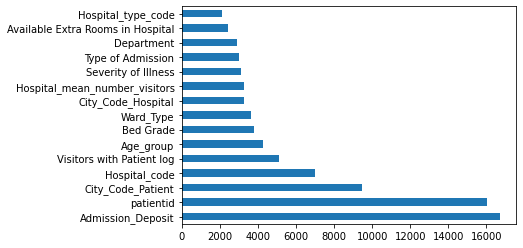

In [202]:
feat_importances = pd.Series(fit_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [203]:
submission.head()

,case_id,Stay
0,318439,0-10
1,318440,51-60
2,318441,21-30
3,318442,21-30
4,318443,51-60


In [204]:
red = pd.DataFrame()
for i in range(1, 6):
    red = pd.concat([red,pd.DataFrame(result[i])],axis=1)
red.columns=['1','2','3','4','5']

In [205]:
red.head()

,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0
1,5.0,5.0,5.0,5.0,5.0
2,2.0,2.0,2.0,2.0,2.0
3,2.0,2.0,2.0,2.0,2.0
4,5.0,5.0,5.0,5.0,5.0


In [206]:
submission['Stay_pred'] = red.mode(axis=1)[0]

In [215]:
submission['Stay_pred'] = red.iloc[:,2]

In [217]:
submission['Stay_pred'] = submission['Stay_pred'].map(inv_map)

In [218]:
submission.head()

,case_id,Stay,Stay_pred
0,318439,0-10,0-10
1,318440,51-60,51-60
2,318441,21-30,21-30
3,318442,21-30,21-30
4,318443,51-60,51-60


In [219]:
submission.drop("Stay",axis=1,inplace=True)

In [220]:
submission.columns = ['case_id','Stay']

In [221]:
submission.dtypes

case_id     int64
Stay       object
dtype: object

In [222]:
submission.to_csv("model_lgb_kfold.csv",index=False)

## Lightgbm

In [118]:
import lightgbm as lgb

In [119]:
train_final.columns

Index(['case_id', 'Hospital_code', 'City_Code_Hospital',
       'Available Extra Rooms in Hospital', 'patientid', 'Severity of Illness',
       'Visitors with Patient', 'Admission_Deposit', 'Stay', 'is_train',
       'Age_group', 'Hospital_type_code', 'Hospital_region_code', 'Department',
       'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Bed Grade',
       'City_Code_Patient', 'Available Extra Rooms in Hospital boxcox',
       'Available Extra Rooms in Hospital log', 'Hospital_per_city_code',
       'Hospital_per_hospital_type', 'Hospital_per_region_code',
       'Hospital_per_department', 'Hospital_per_ward_type',
       'Hospital_per_ward_facility', 'Hospital_per_admission_type',
       'Hospital_per_illness_severity', 'Hospital_per_bed_grade',
       'Hospital_mean_available_rooms', 'Hospital_mean_number_visitors',
       'Hospital_std_available_rooms', 'Hospital_std_number_visitors',
       'Patient_Hospital_city_code', 'Visitors with Patient log',
       'Hospital_me

In [120]:
train_final['Stay'].nunique()

11

In [ ]:
lgb_params = {
    "objective" : "multiclass",
    "num_classes": 11,
    # "device_type":"gpu",
    "metric" : {'multi_logloss'},
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : 88,
    "verbosity" : 1,
    "seed": 88
}

In [ ]:
weights = train_final['Stay'].value_counts()/len(train_final)

In [ ]:
weights = weights.to_dict()

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',
                                                np.unique(train_final['Stay']),
                                                train_final['Stay'])

In [ ]:
def class_weight(labels_dict,mu=0.15):
    total = list(np.sum(labels_dict.values()))
    print(total)
    keys = labels_dict.keys()
    weight = dict()
    for e,i in enumerate(keys):
      numerator = mu*total[e]
      score = np.log(mu*total[e]/float(labels_dict[i]))
      weight[i] = score if score > 1 else 1
    return weight
# random labels_dict
labels_dict = train_final['Stay'].value_counts().to_dict()
weights = class_weight(labels_dict)

[87491, 78139, 55159, 35018, 23604, 11743, 10254, 6683, 4838, 2765, 2744]


In [ ]:
weights

{0.0: 1,
 1.0: 1,
 2.0: 1,
 3.0: 1,
 4.0: 1,
 5.0: 1,
 6.0: 1,
 7.0: 1,
 8.0: 1,
 9.0: 1,
 10.0: 1}

In [ ]:
model = lgb.LGBMClassifier(n_estimators=300,class_weight=weights)
model.fit(train_final[features], train_final['Stay'])

LGBMClassifier(boosting_type='gbdt',
               class_weight={0.0: 1, 1.0: 1, 2.0: 1, 3.0: 1, 4.0: 1, 5.0: 1,
                             6.0: 1, 7.0: 1, 8.0: 1, 9.0: 1, 10.0: 1},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
y_pred = model.predict(test_final[features])

In [ ]:
y_pred

array([0., 5., 2., ..., 1., 1., 3.])

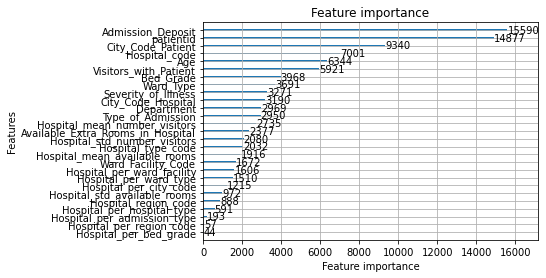

In [ ]:
import matplotlib.pyplot as plt
lgb.plot_importance(model)
plt.show()

In [ ]:
y_pred

array([0., 5., 2., ..., 1., 1., 3.])

In [ ]:
submission.head()

,case_id,Stay
0,318439,0-10
1,318440,51-60
2,318441,21-30
3,318442,21-30
4,318443,51-60


In [ ]:
submission['Stay_pred'] = y_pred

In [ ]:
submission['Stay_pred'] = submission['Stay_pred'].map(inv_map)

In [ ]:
submission.head()

,case_id,Stay,Stay_pred
0,318439,0-10,0-10
1,318440,51-60,51-60
2,318441,21-30,21-30
3,318442,21-30,21-30
4,318443,51-60,51-60


In [ ]:
submission.drop("Stay",axis=1,inplace=True)

In [ ]:
submission.columns = ['case_id','Stay']

In [ ]:
submission.dtypes

case_id     int64
Stay       object
dtype: object

In [ ]:
submission.to_csv("model_lgbm_f1.csv",index=False)

## Vecstack

In [ ]:
features = [col for col in train_final.columns if col not in ['case_id', 'patientid','Stay']]

In [ ]:
!pip install vecstack
from vecstack import stacking

In [ ]:
import lightgbm as lgb
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
clf1 = lgb.LGBMClassifier(n_estimators=300)
#clf2 = RandomForestClassifier(random_state=88,n_estimators=300)
clf2 = LogisticRegression()
clf3 = xgboost.XGBClassifier(n_estimators=300)

In [ ]:
y = train_final['Stay']
models = [clf1, clf2, clf3]
# Compute stacking features
S_train, S_test = stacking(models, train_final[features], y,test_final[features], regression = False, n_folds = 4, shuffle = True, random_state = 88, verbose = 2)
xgb = xgboost.XGBClassifier()
model = xgb
# Fit 2-nd level model
model = model.fit(S_train, y)
# Predict
y_test_pred = model.predict(S_test)

task:         [classification]
n_classes:    [11]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [LGBMClassifier]
    fold  0:  [0.42728300]
    fold  1:  [0.42884060]
    fold  2:  [0.42254017]
    fold  3:  [0.42271602]
    ----
    MEAN:     [0.42534495] + [0.00277280]
    FULL:     [0.42534497]

model  1:     [LogisticRegression]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  0:  [0.37200100]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  1:  [0.37171210]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  2:  [0.36865179]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  3:  [0.36988280]
    ----
    MEAN:     [0.37056192] + [0.00136964]
    FULL:     [0.37056193]

model  2:     [XGBClassifier]
    fold  0:  [0.41843989]
    fold  1:  [0.42033664]
    fold  2:  [0.41522943]
    fold  3:  [0.41539273]
    ----
    MEAN:     [0.41734968] + [0.00214683]
    FULL:     [0.41734969]



In [ ]:
y_test_pred

array([0., 5., 2., ..., 1., 1., 3.])

In [ ]:
submission.head()

,case_id,Stay
0,318439,0-10
1,318440,0-10
2,318441,0-10
3,318442,0-10
4,318443,0-10


In [ ]:
submission['Stay_pred'] = y_test_pred

In [ ]:
submission['Stay_pred'] = submission['Stay_pred'].map(inv_map)

In [ ]:
submission.head()

,case_id,Stay,Stay_pred
0,318439,0-10,0-10
1,318440,0-10,51-60
2,318441,0-10,21-30
3,318442,0-10,21-30
4,318443,0-10,51-60


In [ ]:
submission.drop("Stay",axis=1,inplace=True)

In [ ]:
submission.columns = ['case_id','Stay']

In [ ]:
submission.dtypes

case_id     int64
Stay       object
dtype: object

In [ ]:
submission.to_csv("model_vecstacking.csv",index=False)